In [1]:
%load_ext autoreload
%autoreload 2

import math
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from micrograd import Value, Neuron, Layer, MLP

In [3]:
np.random.seed(42)
random.seed(42)

In [4]:
# Coding the loss function and we allow to choose the modeL (based on different activation functions)
def loss(X, y, model, loss_function, batch_size=None):
        
    # to load a fragment of the data, optional
    if batch_size is None:
        Xb, yb = X, y
    else:
        ri = np.random.permutation(X.shape[0])[:batch_size]
        Xb, yb = X[ri], y[ri]
    # Transforming the X array into a list of Value objects
    inputs = [list(map(Value, xrow)) for xrow in Xb]
        
    # forward the model to get scores
    scores = list(map(model, inputs))
        
    # choosing the loss function, decided to specify in each loss_function the accuracy function, to personalize our dataset (+-1/01..)
    data_loss, accuracy = loss_function(yb, scores)
    # L2 regularization : keep our parameters close
    alpha = 1e-4
    reg_loss = alpha * sum((p*p for p in model.parameters()))
    total_loss = data_loss + reg_loss
        
    return total_loss, accuracy


# some loss_functions
def loss_max_margin(yb, scores):
    # getting -1 and 1 values for the target y
    yb = 2 * yb**2 - 1
    losses = [(1 + -yi*scorei).relu() for yi, scorei in zip(yb, scores)]
    accuracy = [(yi > 0) == (scorei.data > 0) for yi, scorei in zip(yb, scores)]
    return sum(losses) * (1.0 / len(losses)), sum(accuracy)/len(accuracy)

def RMSE(yb, scores):
    losses = [(yi - scorei)**2 for yi, scorei in zip(yb, scores)]
    accuracy = [(yi>1/2) == (scorei.data>1/2) for yi, scorei in zip(yb, scores)]
    return (sum(losses)/len(losses)).sqrt(), sum(accuracy)/len(accuracy)

def MSE_Loss(yb, scores):
    losses = [(yi - scorei)**2 for yi, scorei in zip(yb, scores)]
    accuracy = [(yi > 0.5) == (scorei.data > 0.5) for yi, scorei in zip(yb, scores)]
    return sum(losses) * (1.0 / len(losses)), sum(accuracy)/len(accuracy)


def train(X, y, model, nite, loss_function=loss_max_margin, initial_lr= 0.01):
        
    for k in range(nite):
        # Forward pass
        total_loss, acc = loss(X, y, model, loss_function)

        # Backward pass
        model.zero_grad()
        total_loss.backward()

        # Update : Learning rate decay simple
        #lr = initial_lr * (1.0 - 0.9 * k / nite)
        # Wanted to see the result without lr decay
        lr = initial_lr
        for p in model.parameters():
            p.data -= lr * p.grad
    
        if k % 10 == 0:
            print(f"step {k} | loss {total_loss.data:.4f} | accuracy {acc*100:.1f}%")

def visualize(X, y, model, threshold=0.0): # added a threshold to make it compatible with every loss function
    h = 0.1
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                        np.arange(y_min, y_max, h))
    Xmesh = np.c_[xx.ravel(), yy.ravel()]
    inputs = [list(map(Value, xrow)) for xrow in Xmesh]
    scores = list(map(model, inputs))
        
    Z = np.array([s.data > threshold for s in scores])
        
    Z = Z.reshape(xx.shape)
    fig = plt.figure()
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

(100, 2)

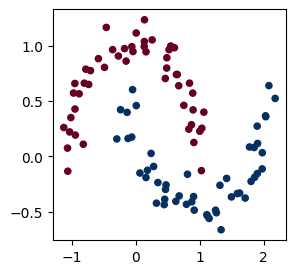

In [18]:
# make a dataset

from sklearn.datasets import make_moons, make_blobs
X, y = make_moons(n_samples=100, noise=0.1)

plt.figure(figsize=(3,3))
plt.scatter(X[:,0], X[:,1], c=y, cmap='RdBu', s=20)
np.shape(X)

step 0 | loss 3.3032 | accuracy 26.0%
step 10 | loss 0.1354 | accuracy 79.0%
step 20 | loss 0.1032 | accuracy 84.0%
step 30 | loss 0.0963 | accuracy 87.0%
step 40 | loss 0.0940 | accuracy 87.0%
step 50 | loss 0.0932 | accuracy 87.0%
step 60 | loss 0.0929 | accuracy 87.0%
step 70 | loss 0.0928 | accuracy 87.0%
step 80 | loss 0.0928 | accuracy 87.0%
step 90 | loss 0.0928 | accuracy 87.0%


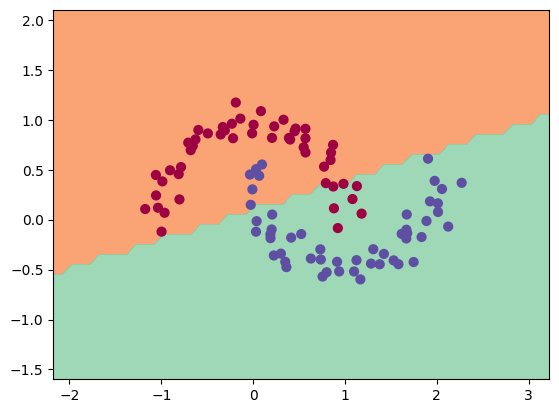

In [13]:
# Let's try using different activation function to visualize the different models : linear, relu, tanh

# Linear Model
linear_model = MLP(nin=2, nouts=[8,8, 1], nonlin=False)
train(X, y, linear_model, nite=100, loss_function=MSE_Loss)
visualize(X, y, linear_model, threshold=0.5)

step 0 | loss 1.0316 | accuracy 55.0%
step 10 | loss 0.6408 | accuracy 89.0%
step 20 | loss 0.6248 | accuracy 88.0%
step 30 | loss 0.6168 | accuracy 89.0%
step 40 | loss 0.5990 | accuracy 90.0%
step 50 | loss 0.5913 | accuracy 92.0%
step 60 | loss 0.5669 | accuracy 89.0%
step 70 | loss 0.5404 | accuracy 95.0%
step 80 | loss 0.5836 | accuracy 94.0%
step 90 | loss 0.5139 | accuracy 99.0%


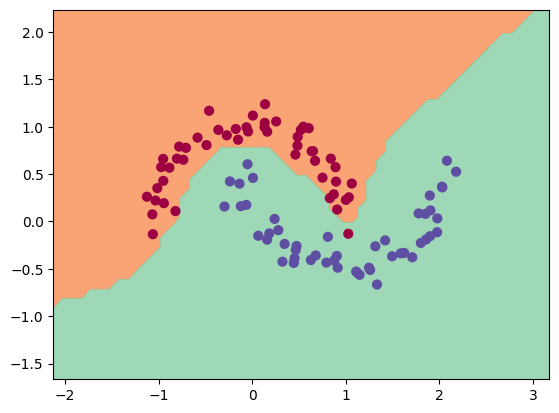

In [ ]:
# Max-margin with relu (original)
original_model = MLP(2, [16, 16, 1])
train(X, y, original_model, 100, initial_lr=1)
visualize(X, y, original_model, threshold=0.0)

step 0 | loss 0.5274 | accuracy 82.0%
step 10 | loss 0.1047 | accuracy 87.0%
step 20 | loss 0.0831 | accuracy 88.0%
step 30 | loss 0.0709 | accuracy 93.0%
step 40 | loss 0.0646 | accuracy 93.0%
step 50 | loss 0.0606 | accuracy 95.0%
step 60 | loss 0.0576 | accuracy 95.0%
step 70 | loss 0.0552 | accuracy 95.0%
step 80 | loss 0.0532 | accuracy 96.0%
step 90 | loss 0.0514 | accuracy 96.0%


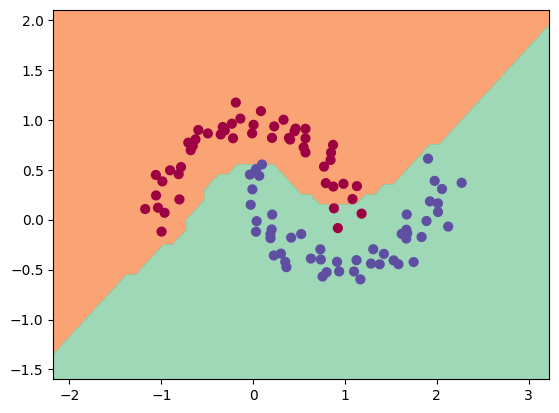

In [17]:
# Trying a final one with MSE and tanh
tanh_model = MLP(2, [16, 16, 1], act_fun=Value.tanh)
train(X, y, tanh_model, 100, loss_function=MSE_Loss, initial_lr=0.1)
visualize(X, y, tanh_model, threshold=0.5)

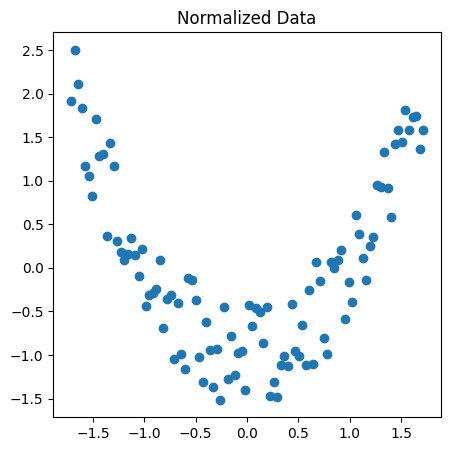

In [5]:
## Now solving a regression problem with our autograd system

#making a dataset to apply regression : x^2 for simplicity
noise = np.random.random(100)-1/2 # btw -1/2 ; 1/2
X_raw = np.linspace(-5, 5, 100)
polynomial = lambda x: x**2
y_raw = polynomial(X_raw) + 10*noise

# Normalize X and y to reasonable ranges for training
X = (X_raw - X_raw.mean()) / X_raw.std()
y = (y_raw - y_raw.mean()) / y_raw.std()

# Reshape X to be 2D for compatibility with the model (100, 1)
X = X.reshape(-1, 1)

plt.figure(figsize=(5,5))
plt.scatter(X, y)
plt.title("Normalized Data")
plt.show()

step 0 | loss 1.0059 | accuracy 73.0%
step 10 | loss 0.9882 | accuracy 73.0%
step 20 | loss 0.9701 | accuracy 73.0%
step 30 | loss 0.9382 | accuracy 73.0%
step 40 | loss 0.8830 | accuracy 73.0%
step 50 | loss 0.7975 | accuracy 73.0%
step 60 | loss 0.6877 | accuracy 73.0%
step 70 | loss 0.5782 | accuracy 73.0%
step 80 | loss 0.4900 | accuracy 73.0%
step 90 | loss 0.4267 | accuracy 82.0%
step 100 | loss 0.3827 | accuracy 91.0%
step 110 | loss 0.3518 | accuracy 92.0%
step 120 | loss 0.3295 | accuracy 95.0%
step 130 | loss 0.3129 | accuracy 97.0%
step 140 | loss 0.3003 | accuracy 97.0%
step 150 | loss 0.2904 | accuracy 97.0%
step 160 | loss 0.2825 | accuracy 96.0%
step 170 | loss 0.2761 | accuracy 95.0%
step 180 | loss 0.2709 | accuracy 95.0%
step 190 | loss 0.2665 | accuracy 94.0%
step 200 | loss 0.2627 | accuracy 94.0%
step 210 | loss 0.2595 | accuracy 94.0%
step 220 | loss 0.2568 | accuracy 94.0%
step 230 | loss 0.2544 | accuracy 94.0%
step 240 | loss 0.2523 | accuracy 93.0%
step 250 | 

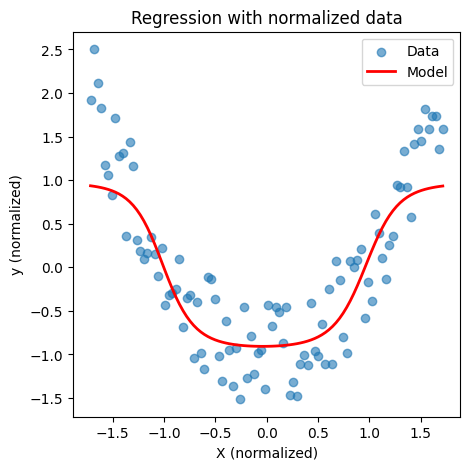

In [24]:
# To make it regression, we use nin=1 and nouts=[*, *, 1]
regression_model = MLP(nin=1, nouts=[2, 1], act_fun=Value.tanh)

# Lower learning rate for better convergence with normalized data
train(X, y, regression_model, 500, loss_function=MSE_Loss, initial_lr=0.1)

# For plotting, reshape predictions to match X
X_plot = X.flatten()
predictions = [regression_model([Value(x)]).data for x in X_plot]

plt.figure(figsize=(5,5))
plt.scatter(X_plot, y, alpha=0.6, label='Data')
plt.plot(X_plot, predictions, 'r-', linewidth=2, label='Model')
plt.xlabel('X (normalized)')
plt.ylabel('y (normalized)')
plt.legend()
plt.title('Regression with normalized data')
plt.show()